In [2]:
%load_ext autoreload
%autoreload 2

from sklego.datasets import load_arrests

from run import run_it


df = load_arrests(give_pandas=True).assign(
    colour=lambda d: (d['colour'] == 'Black') * 1,
    sex=lambda d: (d['sex'] == 'Female') * 1,
    age=lambda d: (d['age'] < 25) * 1,
    released=lambda d: (d['released'] == 'Yes') * 1,
    employed=lambda d: (d['employed'] == 'Yes') * 1,
    citizen=lambda d: (d['citizen'] == 'Yes') * 1,
    jaar = lambda d: d['year'].astype(str),
    checks=lambda d: (d['checks'] - d['checks'].mean()) / d['checks'].std(),
    year=lambda d: (d['year'] - d['year'].mean()) / d['year'].std()
    
)

df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,released,colour,year,age,sex,employed,citizen,checks,jaar
0,1,0,1.791743,1,0,1,1,0.885876,2002
1,0,1,-0.366443,1,0,1,1,0.885876,1999
2,1,0,0.352952,1,0,1,1,0.885876,2000
3,0,1,0.352952,0,0,1,1,-0.413475,2000
4,1,1,-0.366443,0,1,1,1,-0.413475,1999


In [3]:
df.groupby(['citizen', 'employed']).size().reset_index()

,citizen,employed,0
0,0,0,224
1,0,1,547
2,1,0,891
3,1,1,3564


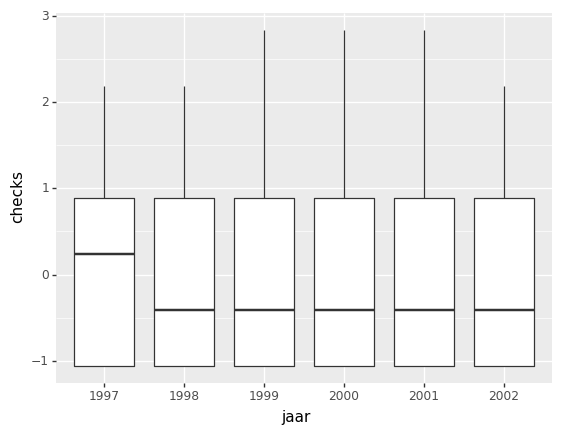

<ggplot: (-9223372036574274763)>

In [4]:
import plotnine as p9 

(p9.ggplot() + p9.geom_boxplot(data=df, mapping=p9.aes('jaar', 'checks')))

In [30]:
import pymc3 as pm
from scipy.special import expit

def unbalanced_model(df):
    def predict(trace, df):
        X = df[['year', 'employed', 'citizen', 'checks']].values
        return expit((trace['intercept'][:, None] + trace['weights'] @ X.T).mean(axis=0))
    
    X = df[['year', 'employed', 'citizen', 'checks']].values
    X_colour, X_non_colour = X[df['colour'] == 1], X[df['colour'] == 0] 
    with pm.Model() as unbalanced_model:
        intercept = pm.Normal('intercept', 0, 1)
        weights = pm.Normal('weights', 0, 1, shape=X.shape[1])

        p = pm.math.sigmoid(intercept + pm.math.dot(X, weights))
        
        dist_colour = intercept + pm.math.dot(X_colour, weights)
        dist_non_colour = intercept + pm.math.dot(X_non_colour, weights)
        mu_diff = pm.Deterministic('mu_diff', dist_colour.mean() - dist_non_colour.mean())

        pm.Bernoulli('released', p, observed=df['released'])

        unbalanced_trace = pm.sample(tune=1000, draws=1000, chains=6)
        
    return unbalanced_trace, predict

    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [weights, intercept]
Sampling 6 chains, 0 divergences: 100%|██████████| 12000/12000 [00:23<00:00, 515.09draws/s]
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Ar

accuracy: 0.8310371220818982
precision: 0.8356350904493289
recall: 0.9912321181356715
eq op score: 0.9802678187896483
dem par score: 0.9667063412555298


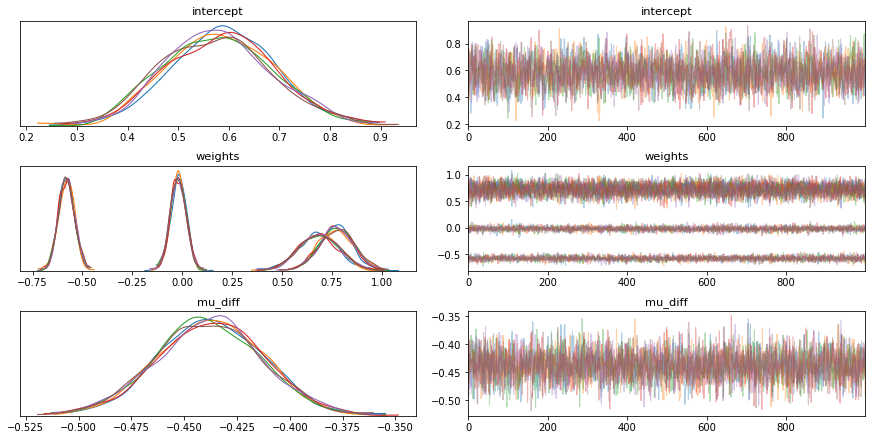

In [31]:
run_it(unbalanced_model, df)

In [28]:
def balanced_model(df):
    def predict(trace, df):
        X = df[['year', 'employed', 'citizen', 'checks']].values
        return expit((trace['intercept'][:, None] + trace['weights'] @ X.T).mean(axis=0))
    
    X = df[['year', 'employed', 'citizen', 'checks']].values
    class_weights = len(df) / df['released'].value_counts()
    sample_weights = df['released'].map(class_weights)
    X_colour, X_non_colour = X[df['colour'] == 1], X[df['colour'] == 0] 

    
    with pm.Model() as balanced_model:
        intercept = pm.Normal('intercept', 0, 1)
        weights = pm.Normal('weights', 0, 1, shape=X.shape[1])

        p = pm.math.sigmoid(intercept + pm.math.dot(X, weights))
        
        dist_colour = intercept + pm.math.dot(X_colour, weights)
        dist_non_colour = intercept + pm.math.dot(X_non_colour, weights)
        mu_diff = pm.Deterministic('mu_diff', dist_colour.mean() - dist_non_colour.mean())

        pm.Potential('balance', sample_weights.values * pm.Bernoulli.dist(p).logp(df['released'].values))


        balanced_trace = pm.sample(tune=1000, draws=1000, chains=6)
       
    return balanced_trace, predict

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [weights, intercept]
Sampling 6 chains, 0 divergences: 100%|██████████| 12000/12000 [00:26<00:00, 445.42draws/s]
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Ar

accuracy: 0.647148871029468
precision: 0.9194743935309974
recall: 0.629672358098754
eq op score: 0.6912159760396099
dem par score: 0.6268834653492812


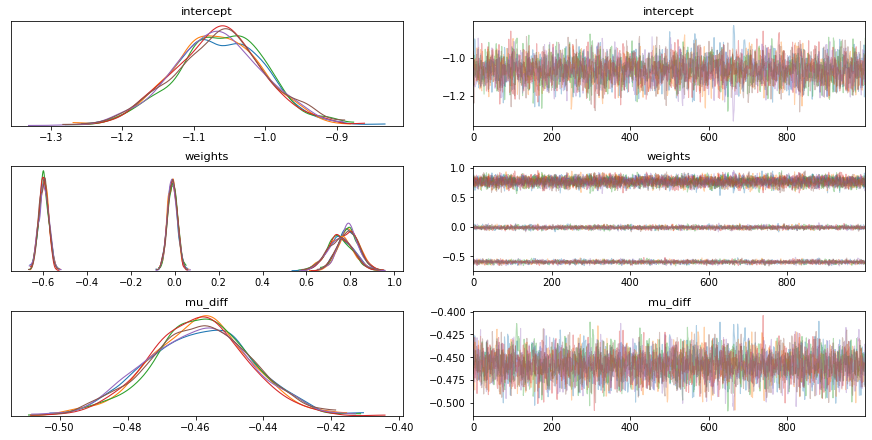

In [29]:
run_it(balanced_model, df)

In [36]:
def dem_par_model(df):
    def predict(trace, df):
        X = df[['year', 'employed', 'citizen', 'checks']].values
        return expit((trace['intercept'][:, None] + trace['weights'] @ X.T).mean(axis=0))
    
    X = df[['year', 'employed', 'citizen', 'checks']].values
    X_colour, X_non_colour = X[df['colour'] == 1], X[df['colour'] == 0] 

    
    class_weights = len(df) / df['released'].value_counts()
    sample_weights = df['released'].map(class_weights)
    with pm.Model() as dem_par_model:
        intercept = pm.Normal('intercept', 0, 1)
        weights = pm.Normal('weights', 0, 1, shape=X.shape[1])

        p = pm.math.sigmoid(intercept + pm.math.dot(X, weights))

        dist_colour = intercept + pm.math.dot(X_colour, weights)
        dist_non_colour = intercept + pm.math.dot(X_non_colour, weights)
        mu_diff = pm.Deterministic('mu_diff', dist_colour.mean() - dist_non_colour.mean())

        pm.Potential('dist', pm.Normal.dist(0, 0.01).logp(mu_diff))
        pm.Potential('balance', sample_weights.values * pm.Bernoulli.dist(p).logp(df['released'].values))

        dem_par_trace = pm.sample(tune=1000, draws=1000, chains=6)
       
    return dem_par_trace, predict

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [weights, intercept]
Sampling 6 chains, 0 divergences: 100%|██████████| 12000/12000 [00:25<00:00, 466.53draws/s]
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Ar

accuracy: 0.6590126291618829
precision: 0.9030322173089071
recall: 0.6596677434240886
eq op score: 0.8107786776390722
dem par score: 0.7640615919551362


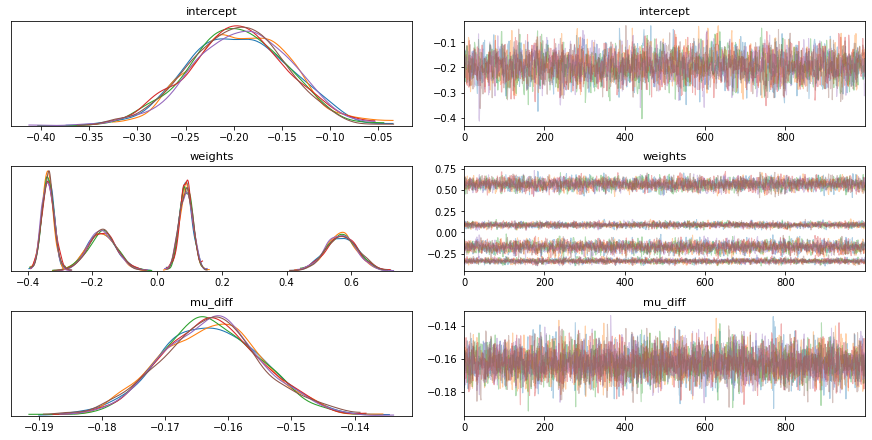

In [37]:
trace, predictor = run_it(dem_par_model, df)

In [166]:
import numpy as np

def trace_filter(trace, threshold_val):
    mask = np.abs(trace['mu_diff']) < threshold_val
    print(f"starting trace length: {len(trace['mu_diff'])}")
    print(f'remainder: {mask.sum()}')
    strace = trace._straces[0]
    new_strace = pm.backends.NDArray(model=strace.model, vars=strace.vars)
    
    samples = {varname: trace[varname][mask] for varname in trace.varnames}
    new_strace.samples = samples
    new_strace.draws = mask.sum()
    new_strace.draw_idx = mask.sum()
    new_strace.chain = 0
    return pm.backends.base.MultiTrace([new_strace])
    

def hard_constraint_model(df):
    def predict(trace, df):
        X = df[['year', 'employed', 'citizen', 'checks']].values
        return expit((trace['intercept'][:, None] + trace['weights'] @ X.T).mean(axis=0))
    
    X = df[['year', 'employed', 'citizen', 'checks']].values
    X_colour, X_non_colour = X[df['colour'] == 1], X[df['colour'] == 0] 

    
    class_weights = len(df) / df['released'].value_counts()
    sample_weights = df['released'].map(class_weights)
    with pm.Model() as dem_par_model:
        intercept = pm.Normal('intercept', 0, 1)
        weights = pm.Normal('weights', 0, 1, shape=X.shape[1])

        p = pm.math.sigmoid(intercept + pm.math.dot(X, weights))

        dist_colour = intercept + pm.math.dot(X_colour, weights)
        dist_non_colour = intercept + pm.math.dot(X_non_colour, weights)
        mu_diff = pm.Deterministic('mu_diff', dist_colour.mean() - dist_non_colour.mean())

        pm.Potential('dist', pm.Normal.dist(0, 0.01).logp(mu_diff))
        pm.Potential('balance', sample_weights.values * pm.Bernoulli.dist(p).logp(df['released'].values))

        dem_par_trace = pm.sample(tune=1000, draws=1000, chains=6)
    return trace_filter(dem_par_trace, 0.16), predict


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [weights, intercept]
Sampling 6 chains, 0 divergences: 100%|██████████| 12000/12000 [00:22<00:00, 523.17draws/s]


starting trace length: 6000
remainder: 2237
accuracy: 0.6718331419823957
precision: 0.8959782280012095
recall: 0.6836640516843563
eq op score: 0.835474535141003
dem par score: 0.7826523366822908


/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/matthijsbrouns/PycharmProjects/potential_prior/venv/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


(<MultiTrace: 1 chains, 2237 iterations, 3 variables>,
 <function __main__.hard_constraint_model.<locals>.predict(trace, df)>)

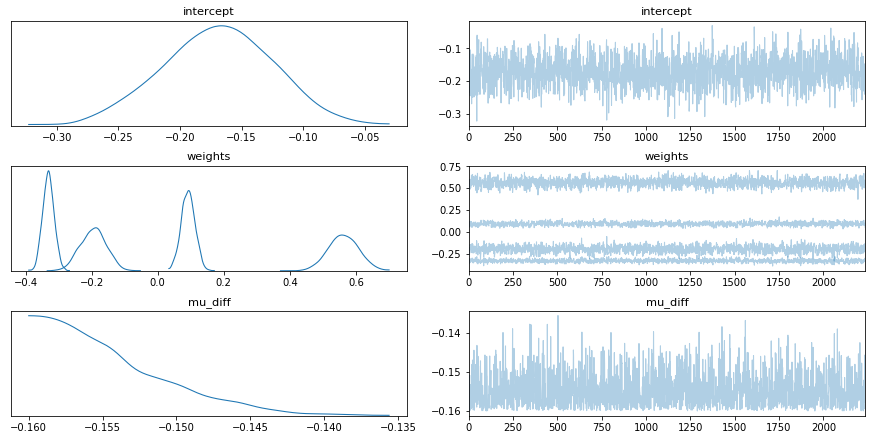

In [167]:
run_it(hard_constraint_model, df)